DeepFilm: 基于深度学习和高质量数据集的胶片模型

---

训练胶片风格到数码风格的转换（柯达金200转换到数码风格）的模型。

---

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import tqdm
import math
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    print("GPU可用！")
else:
    print("GPU不可用，将使用CPU进行计算。")

GPU不可用，将使用CPU进行计算。


In [3]:
class ImagePairDataset(Dataset):
    def __init__(self, folder1, folder2, pairs, transform=None, enhance_transform_1 = None, 
                 enhance_transform_2 = None, enhance_transform_3 = None):
        self.folder1 = folder1
        self.folder2 = folder2
        self.pairs = pairs
        self.transform = transform
        self.enhance_transform_1 = enhance_transform_1
        self.enhance_transform_2 = enhance_transform_2
        self.enhance_transform_3 = enhance_transform_3
        self.image_pairs = self.read_image_pairs()

    def read_image_pairs(self):
      image_pairs = []
      for image_pair in tqdm.tqdm(self.pairs):
        img1_path = os.path.join(self.folder1, image_pair[0])
        img2_path = os.path.join(self.folder2, image_pair[1])
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
        img3 = img1
        img4 = img2
        img5 = img1
        img6 = img2
        img7 = img1
        img8 = img2
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        if self.enhance_transform_1:
            img3 = self.enhance_transform_1(img3)
            img4 = self.enhance_transform_1(img4)
        if self.enhance_transform_2:
            img5 = self.enhance_transform_2(img5)
            img6 = self.enhance_transform_2(img6)
        if self.enhance_transform_3:
            img7 = self.enhance_transform_3(img7)
            img8 = self.enhance_transform_3(img8)
        image_pairs.append((img1, img2))
        image_pairs.append((img3, img4))
        image_pairs.append((img5, img6))
        image_pairs.append((img7, img8))
      return image_pairs
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
      return self.image_pairs[idx][0], self.image_pairs[idx][1]

In [4]:
def show_paired_images(dataset, batch_size=4):
  # Create DataLoader
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  for img1, img2 in dataloader:
    # Convert tensor to numpy for plotting
    img1 = img1.permute(0, 2, 3, 1).numpy()  # Change to (batch_size, height, width, channels)
    img2 = img2.permute(0, 2, 3, 1).numpy()

    # Plot pairs of images
    fig, axes = plt.subplots(batch_size, 2, figsize=(8, batch_size * 4))
    for i in range(batch_size):
      axes[i, 0].imshow(img1[i])
      axes[i, 0].axis('off')  # Hide axes
      axes[i, 0].set_title(f"Image 1 - Pair {i+1}")

      axes[i, 1].imshow(img2[i])
      axes[i, 1].axis('off')  # Hide axes
      axes[i, 1].set_title(f"Image 2 - Pair {i+1}")

    plt.tight_layout()
    plt.show()
    break  # Show only one batch for simplicity

In [5]:
# Define paths to the folders
digital_dir = "D:/data/胶片-数码/数码"
film_dir = "D:/data/胶片-数码/伪胶片"

In [6]:
# Get the list of files in both folders
digital = sorted(os.listdir(digital_dir))
film = sorted(os.listdir(film_dir))

print(len(digital))
print(len(film))

# Ensure the number of files match
if len(digital) != len(film):
    raise ValueError("The two folders must have the same number of images.")

# Create pairs of images (file1, file2)
pairs = list(zip(digital, film))

# Split into training and testing sets
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

1517
1517


In [6]:
# Define transformations (if needed)
transform = transforms.Compose([
  # transforms.Resize((200, 320)),
  transforms.ToTensor()
])
enhance_transform_1 = transforms.Compose([
  transforms.RandomRotation(degrees=(-180, -180), expand=True),
  transforms.Resize((200, 320)),
  transforms.ToTensor(),
])
enhance_transform_2 = transforms.Compose([
  transforms.CenterCrop(330),
  transforms.Resize((200, 320)),
  transforms.ToTensor(),
])
enhance_transform_3 = transforms.Compose([
  transforms.RandomRotation(degrees=(-90, -90), expand=True),
  transforms.Resize((200, 320)),
  transforms.ToTensor(),
])

In [7]:
batch_size = 16

In [56]:
# Create datasets
train_dataset = ImagePairDataset(digital_dir, film_dir, train_pairs, transform=transform, 
                                 enhance_transform_1=enhance_transform_1,
                                 enhance_transform_2=enhance_transform_2,
                                 enhance_transform_3 = enhance_transform_3)
test_dataset = ImagePairDataset(digital_dir, film_dir, test_pairs, transform=transform, 
                                enhance_transform_1=enhance_transform_1,
                                enhance_transform_2=enhance_transform_2,
                                enhance_transform_3 = enhance_transform_3)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, drop_last=True)

100%|██████████| 304/304 [01:09<00:00,  4.40it/s]


In [8]:
# 通道注意力机制 (Channel Attention Mechanism)
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class FilmStyleTransfer(torch.nn.Module):
    def __init__(self):
        super(FilmStyleTransfer, self).__init__()

        # 定义卷积层
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = torch.nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv7 = torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv8 = torch.nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        
        # 定义激活函数
        self.leakyrelu = torch.nn.LeakyReLU()
        
        # 定义BatchNorm层
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.bn5 = torch.nn.BatchNorm2d(128)
        self.bn6 = torch.nn.BatchNorm2d(64)
        self.bn7 = torch.nn.BatchNorm2d(32)

        # 注意力机制
        self.ca2 = ChannelAttention(64)
        self.ca3 = ChannelAttention(128)
        self.ca4 = ChannelAttention(256)
        self.ca5 = ChannelAttention(128)
        self.ca6 = ChannelAttention(64)
        self.ca7 = ChannelAttention(32)
        
        # 跳跃连接的卷积层
        self.skip1 = torch.nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0)  # 将32通道映射到3通道
        self.skip2 = torch.nn.Conv2d(64, 3, kernel_size=1, stride=1, padding=0)  # 将64通道映射到3通道
        
    def forward(self, x):
        x1 = (self.leakyrelu(self.bn1(self.conv1(x))))
        x2 = self.ca2(self.leakyrelu(self.bn2(self.conv2(x1))))
        x3 = self.ca3(self.leakyrelu(self.bn3(self.conv3(x2))))
        x4 = self.ca4(self.leakyrelu(self.bn4(self.conv4(x3))))
        x5 = self.ca5(self.leakyrelu(self.bn5(self.conv5(x4))))
        x6 = self.ca6(self.leakyrelu(self.bn6(self.conv6(x5))))
        x7 = self.ca7(self.leakyrelu(self.bn7(self.conv7(x6))))
        x8 = self.conv8(x7)
        
        # 跳跃连接
        skip1 = self.skip1(x1)  # 将x1的32通道映射到3通道
        skip2 = self.skip2(x2)  # 将x2的64通道映射到3通道
        
        # 合并跳跃连接和最终输出
        output = x8 + skip1 + skip2

        return output

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
model = FilmStyleTransfer()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.SmoothL1Loss(reduction='mean')
pre_epochs = 0

In [11]:
checkpoint = torch.load("models/生成器/generate_gold_200_training_100.pt")

# 恢复模型和优化器状态
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
pre_epochs = checkpoint['epoch']

# 恢复训练状态
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [10]:
def psnr(target, prediction, max_pixel=1.0):
    mse = torch.nn.functional.mse_loss(target, prediction)
    if mse == 0:
        return float('inf')  # 如果 MSE 为 0，意味着两图完全相同
    return 20 * math.log10(max_pixel / math.sqrt(mse))

def evaluate_psnr_generate(data_loader, model, max_pixel=1.0):
    total_psnr = 0.0
    num_images = 0

    # 遍历数据集
    for generated_images, original_images in data_loader:
        # 确保输入输出图像在相同的设备上（例如：GPU）
        original_images = original_images.to(device)
        generated_images = generated_images.to(device)

        # 计算每一对图像的 PSNR
        for orig, gen in zip(original_images, generated_images):
            orig = orig.unsqueeze(0).cuda()  # 增加批量维度
            output = model(orig)
            psnr_value = psnr(gen, output[0], max_pixel=max_pixel)
            total_psnr += psnr_value
            num_images += 1

    # 计算整个数据集的平均 PSNR
    avg_psnr = total_psnr / num_images if num_images > 0 else 0.0
    return avg_psnr

def evaluate_psnr_pre_train(data_loader, model, max_pixel=1.0):
    total_psnr = 0.0
    num_images = 0

    # 遍历数据集
    for generated_images, original_images in data_loader:
        # 确保输入输出图像在相同的设备上（例如：GPU）
        original_images = original_images.to(device)
        generated_images = generated_images.to(device)

        # 计算每一对图像的 PSNR
        for orig, gen in zip(original_images, generated_images):
            gen = gen.unsqueeze(0).cuda()  # 增加批量维度
            output = model(gen)
            psnr_value = psnr(orig, output[0], max_pixel=max_pixel)
            total_psnr += psnr_value
            num_images += 1

    # 计算整个数据集的平均 PSNR
    avg_psnr = total_psnr / num_images if num_images > 0 else 0.0
    return avg_psnr

In [11]:
def postprocess_image(tensor):
    """将模型输出的张量转换为 PIL 图像"""
    tensor = tensor.squeeze(0)  # 去掉 batch 维度
    tensor = tensor.clamp(0, 1)  # 确保值在 [0, 1] 范围内
    transform = transforms.ToPILImage()  # 转换为 PIL 图像
    image = transform(tensor)
    return image

In [ ]:
# 训练模型
num_epochs = 110
psnr_list = []

with tqdm.tqdm(total=num_epochs, desc="进度条") as pbar:
    for epoch in range(num_epochs):
        model.train()
        for i, (img1, img2) in enumerate(train_loader):
            img1, img2 = img1.to(device), img2.to(device)
            optimizer.zero_grad()
            reconstructed = model(img2)
            loss = loss_function(reconstructed, img1)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())
        pbar.update(1)
        if not ((epoch + 1 + pre_epochs) % (100)):
            model.eval()
            checkpoint = {
                'epoch': epoch + pre_epochs + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }
            print("Epoch: %s" % str(epoch + 1 + pre_epochs))
            torch.save(checkpoint, 'generate_gold_200_training_' + str(epoch + pre_epochs + 1) + '.pt')
            print("checkpoint: %s saved." % str(epoch + pre_epochs + 1))
            avg_psnr = evaluate_psnr_generate(test_loader, model)
            print(f'Average PSNR for the dataset: {avg_psnr:.2f} dB')
        elif not ((epoch + 1 + pre_epochs) % (10)):
            model.eval()
            avg_psnr = evaluate_psnr_generate(test_loader, model)
            print("Epoch: %s" % str(epoch + 1 + pre_epochs))
            print(f'Average PSNR for the dataset: {avg_psnr:.2f} dB')
            img1, img2 = test_dataset[8]
            img2 = img2.unsqueeze(0).cuda()
            output = model(img2)
            loss = loss_function(output, img1.cuda())
            output = postprocess_image(output)
            output_path =  "./img_epoch_" + str(epoch + pre_epochs + 1) + ".jpg"
            output.save(output_path)
            psnr_list.append(avg_psnr)

In [ ]:
# 测试阶段：展示结果
with torch.no_grad():
    img1, img2 = test_dataset[80]  # 取一个示例
    img2 = img2.unsqueeze(0).cuda()  # 增加批量维度
    output = model(img2)
    
    # 将结果从 Tensor 转换回图片
    output_img = postprocess_image(output)
    img2 = img2.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img1 = img1.numpy().transpose(1, 2, 0)

    # 使用 matplotlib 显示图片
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img2)
    axes[0].set_title("Input Image")
    axes[1].imshow(img1)
    axes[1].set_title("Ground Truth")
    axes[2].imshow(output_img)
    axes[2].set_title("Predicted Image")
    plt.show()

由训练的模型，将真实胶片照片转换为数码风格的照片以便后面训练数码至胶片转换的模型。

---

In [12]:
class SampleImageFolderDataset(Dataset):
    def __init__(self, image_folder, transform = None):
        self.image_folder = image_folder
        img_list = os.listdir(image_folder)
        #img_list.sort(key=lambda x: int(x[5:-4]))
        self.image_paths = [os.path.join(image_folder, f) for f in img_list if os.path.isfile(os.path.join(image_folder, f))]
        self.transform = transform
        self.images = self.read_images()
    
    def read_images(self):
        images = []
        for image_path in tqdm.tqdm(self.image_paths):            
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [ ]:
SampleDataset = SampleImageFolderDataset("D:/data/高清样片/jpg", transform)
SampleDataloader = DataLoader(SampleDataset, batch_size=1, shuffle=False)

In [ ]:
# 测试阶段：展示结果
with torch.no_grad():
    img1 = SampleDataset[200]  # 取一个示例
    img1 = img1.unsqueeze(0).cuda()  # 增加批量维度
    output = model(img1)
    # 将结果从 Tensor 转换回图片
    output_img = postprocess_image(output)

    img1 = img1.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # 使用 matplotlib 显示图片
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].imshow(img1)
    axes[0].set_title("Ground Truth")
    axes[1].imshow(output_img)
    axes[1].set_title("Predicted Image")
    plt.show()

In [13]:
def gaussian_film_grain(image, 
                        noise_intensity=0.1, 
                        blur_radius=3, 
                        blur_sigma=1.0,
                        dark_boost=0.3):
    """
    基于高斯模糊的胶片颗粒模拟
    Args:
        image (Tensor): 输入图像 [C,H,W] 或 [B,C,H,W], 范围 [0,1]
        noise_intensity (float): 基础噪声强度 (0.05~0.3)
        blur_radius (int): 高斯模糊核大小 (奇数)
        blur_sigma (float): 模糊强度 (0.1~3.0)
        dark_boost (float): 暗区颗粒增强系数 (0.0~1.0)
    Returns:
        Tensor: 添加颗粒后的图像
    """
    # 生成基础噪声
    noise = torch.randn_like(image) * noise_intensity
    # 应用高斯模糊（关键步骤）
    if blur_radius > 0:
        # 确保模糊核为奇数
        blur_radius = blur_radius + 1 if blur_radius % 2 == 0 else blur_radius
        noise = torchvision.transforms.functional.gaussian_blur(noise, kernel_size=blur_radius, sigma=blur_sigma)
    
    # 暗区增强 (颗粒在暗部更明显)
    if dark_boost > 0:
        luminance = 0.299 * image[...,0,:,:] + 0.587 * image[...,1,:,:] + 0.114 * image[...,2,:,:]
        dark_mask = (1.0 - luminance) * dark_boost  # 暗区获得更高权重
        noise *= (1.0 + dark_mask)
    
    # 叠加并裁剪
    return torch.clamp(image + noise, 0.0, 1.0)

In [14]:
def process_images(output_file, model, SampleDataset = None,noise = False, noise_intensity=0.1, 
                        blur_radius=3, 
                        blur_sigma=1.0,
                        dark_boost=0.3):
    """
    从文件夹读取图像，运行模型并保存输出。

    参数:
        input_folder (str): 输入图像文件夹路径。
        output_file (str): 输出文件路径。
        model (torch.nn.Module): 训练好的模型。
        batch_size (int): 批量大小。
        save_as (str): 输出文件格式，支持 'pt'（PyTorch 张量）或 'npy'（NumPy 数组）。
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # 创建数据集和数据加载器
    dataloader = SampleDataset

    pre = "digital_"
    with torch.no_grad():
        for i in tqdm.tqdm(range(dataloader.__len__())):
            input = dataloader[i].unsqueeze(0)
            input = input.to(device)
            output= model(input)
            # 将输出张量转换为图像并保存
            for j in range(output.shape[0]):
                if noise:
                    output[j] = gaussian_film_grain(output[j].cpu(), noise_intensity, 
                                                    blur_radius,
                                                    blur_sigma,
                                                    dark_boost)
                    output[j] = output[j].to(device)
                output_image = postprocess_image(output[j])
                # 保存图像
                output_path = output_file + "//" + pre + str(i + 1) + ".jpg"
                output_image.save(output_path)
                i = i + 1

In [ ]:
process_images("D:/data/样片标签", model, SampleImageFolderDataset=SampleDataset)

训练数码至胶片（柯达金200）风格转换的模型。

---

预训练

In [15]:
pre_train_model = FilmStyleTransfer()
pre_train_model = pre_train_model.to(device)
optimizer = optim.Adam(pre_train_model.parameters(), lr=0.0001)
loss_function = torch.nn.SmoothL1Loss(reduction='mean')
pre_train_pre_epochs = 0

In [57]:
checkpoint = torch.load("./models/预训练/pre_train_gold_200_training_100.pt")

# 恢复模型和优化器状态
pre_train_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model = pre_train_model.to(device)
pre_train_model.eval()
pre_train_pre_epochs = checkpoint['epoch']

# 恢复训练状态
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [59]:
# 训练模型
num_epochs = 200
psnr_list = []

with tqdm.tqdm(total=num_epochs, desc="进度条") as pbar:
    for epoch in range(num_epochs):
        pre_train_model.train()
        for i, (img1, img2) in enumerate(train_loader):
            img1, img2 = img1.cuda(), img2.cuda()
            optimizer.zero_grad()
            reconstructed = pre_train_model(img1)
            loss = loss_function(reconstructed, img2)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())
        pbar.update(1)
        if not ((epoch + 1 + pre_train_pre_epochs) % (100)):
            pre_train_model.eval()
            checkpoint = {
                'epoch': epoch + pre_train_pre_epochs + 1,
                'model_state_dict': pre_train_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }
            torch.save(checkpoint, 'pre_train_gold_200_training_' + str(epoch + pre_train_pre_epochs + 1) + '.pt')
            print("checkpoint: %s saved." % str(epoch + pre_train_pre_epochs + 1))
            avg_psnr = evaluate_psnr_pre_train(test_loader, pre_train_model)
            print(f'Average PSNR for the dataset: {avg_psnr:.2f} dB')

进度条:  50%|█████     | 100/200 [13:47<13:46,  8.26s/it, loss=0.0103]

checkpoint: 200 saved.


进度条:  50%|█████     | 100/200 [13:51<13:46,  8.26s/it, loss=0.00727]

Average PSNR for the dataset: 18.77 dB


进度条: 100%|██████████| 200/200 [27:48<00:00,  8.45s/it, loss=0.00767]

checkpoint: 300 saved.


进度条: 100%|██████████| 200/200 [27:52<00:00,  8.36s/it, loss=0.00767]

Average PSNR for the dataset: 18.77 dB


微调模型

In [15]:
other_pre_train_model = FilmStyleTransfer()
other_pre_train_model = other_pre_train_model.to(device)
optimizer = optim.Adam(other_pre_train_model.parameters(), lr=0.0001)
loss_function = torch.nn.SmoothL1Loss(reduction='mean')
pre_train_pre_epochs = 0

In [16]:
checkpoint = torch.load("./app/kodark_gold_200.pt", map_location=device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 恢复模型和优化器状态
other_pre_train_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
other_pre_train_model = other_pre_train_model.to(device)
other_pre_train_model.eval()
pre_train_pre_epochs = checkpoint['epoch']

# 恢复训练状态
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [16]:
# Define paths to the folders
film_dir = "D:/data/微调数据集/胶片"
digital_dir = "D:/data/微调数据集/数码"

In [21]:
# Get the list of files in both folders
digital = sorted(os.listdir(digital_dir))
film = sorted(os.listdir(film_dir))

print(len(digital))
print(len(film))

# Ensure the number of files match
if len(digital) != len(film):
    raise ValueError("The two folders must have the same number of images.")

# Create pairs of images (file1, file2)
pairs = list(zip(digital, film))

# Split into training and testing sets
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

363
363


In [22]:
# Create datasets
train_dataset = ImagePairDataset(digital_dir, film_dir, train_pairs, transform=transform, 
                                 enhance_transform_1=enhance_transform_1,
                                 enhance_transform_2=enhance_transform_2,
                                 enhance_transform_3 = enhance_transform_3)
test_dataset = ImagePairDataset(digital_dir, film_dir, test_pairs, transform=transform, 
                                enhance_transform_1=enhance_transform_1,
                                enhance_transform_2=enhance_transform_2,
                                enhance_transform_3 = enhance_transform_3)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, drop_last=True)

100%|██████████| 73/73 [01:25<00:00,  1.17s/it]


In [23]:
# 训练模型
num_epochs = 300
psnr_list = []

with tqdm.tqdm(total=num_epochs, desc="进度条") as pbar:
    for epoch in range(num_epochs):
        other_pre_train_model.train()
        for i, (img1, img2) in enumerate(train_loader):
            img1, img2 = img1.cuda(), img2.cuda()
            optimizer.zero_grad()
            reconstructed = other_pre_train_model(img1)
            loss = loss_function(reconstructed, img2)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())
        pbar.update(1)
        if not ((epoch + 1 + pre_train_pre_epochs) % (100)):
            other_pre_train_model.eval()
            checkpoint = {
                'epoch': epoch + pre_train_pre_epochs + 1,
                'model_state_dict': other_pre_train_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }
            torch.save(checkpoint, 'final_gold_200_training_' + str(epoch + pre_train_pre_epochs + 1) + '.pt')
            print("checkpoint: %s saved." % str(epoch + pre_train_pre_epochs + 1))
            avg_psnr = evaluate_psnr_pre_train(test_loader, other_pre_train_model)
            print(f'Average PSNR for the dataset: {avg_psnr:.2f} dB')

进度条:  33%|███▎      | 100/300 [03:26<06:47,  2.04s/it, loss=0.0397] 

checkpoint: 400 saved.


进度条:  33%|███▎      | 100/300 [03:27<06:47,  2.04s/it, loss=0.0175]

Average PSNR for the dataset: 22.35 dB


进度条:  67%|██████▋   | 200/300 [06:54<03:26,  2.06s/it, loss=0.0384]  

checkpoint: 500 saved.


进度条:  67%|██████▋   | 200/300 [06:55<03:26,  2.06s/it, loss=0.00456]

Average PSNR for the dataset: 22.50 dB


进度条: 100%|██████████| 300/300 [10:17<00:00,  2.00s/it, loss=0.00242] 

checkpoint: 600 saved.


进度条: 100%|██████████| 300/300 [10:18<00:00,  2.06s/it, loss=0.00242]

Average PSNR for the dataset: 21.77 dB


In [9]:
SampleDataset = SampleImageFolderDataset("D:/胶片数据集/柯达金200/测试照片", transform)
SampleDataloader = DataLoader(SampleDataset, batch_size=6, shuffle=False)

NameError: name 'SampleImageFolderDataset' is not defined

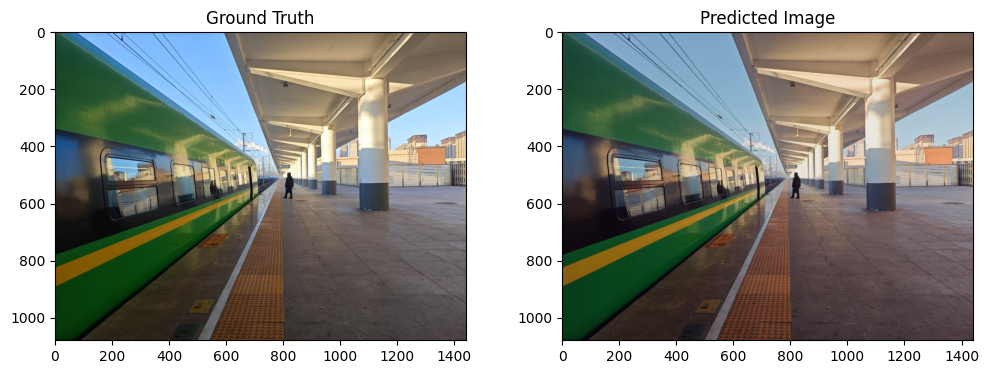

In [22]:
# 测试阶段：展示结果
with torch.no_grad():
    other_pre_train_model.eval()
    img1 = SampleDataset[0]  # 取一个示例
    img1 = img1.unsqueeze(0)  # 增加批量维度
    img1 = img1.to(device)
    output = other_pre_train_model(img1)
    # 将结果从 Tensor 转换回图片
    output_img = postprocess_image(output)
    
    img1 = img1.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # 使用 matplotlib 显示图片
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].imshow(img1)
    axes[0].set_title("Ground Truth")
    axes[1].imshow(output_img)
    axes[1].set_title("Predicted Image")
    plt.show()

In [71]:
output_img.save("./first_film_4.jpg")

In [27]:
process_images("D:/胶片数据集/柯达金200/输出", other_pre_train_model, noise=True, SampleDataset = SampleDataset,
                        noise_intensity=0.03, 
                        blur_radius=1, 
                        blur_sigma=0.5,
                        dark_boost=0.3)

100%|██████████| 3/3 [00:13<00:00,  4.46s/it]
